In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import librosa as lb
import librosa.display as lbd
import os

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
train=pd.read_csv('/content/drive/MyDrive/Classification-of-Lung-Sound/train.csv')
val=pd.read_csv('/content/drive/MyDrive/Classification-of-Lung-Sound/val.csv')
train.head()

,Unnamed: 0,pid,filename,disease
0,1620,151,151_2p2_Al_mc_AKGC417L_3.wav,COPD
1,2141,121,121_1b1_Tc_sc_Meditron_2.wav,Healthy
2,524,160,160_2b4_Pl_mc_AKGC417L_2.wav,COPD
3,3334,102,102_1b1_Ar_sc_Meditron_0.wav,Healthy
4,1381,145,145_3b2_Ar_mc_AKGC417L_5.wav,COPD


In [ ]:
ytrain=train.disease
yval=val.disease
yval

0       COPD
1       COPD
2       COPD
3       COPD
4       COPD
        ... 
1720    COPD
1721    COPD
1722    COPD
1723    COPD
1724    COPD
Name: disease, Length: 1725, dtype: object

* As our class labels are of **dtype: object** we must first convert them to **encoded values** or intergers

In [ ]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
ytrain=le.fit_transform(ytrain)
yval=le.transform(yval)

# Feature Extraction

> I am going to use Librosa's feature extraction methods here

> Note:- i first tried to extract features **1-by-1** and then test them, to see how they perform but most of then were giving **good accuracy** so i finally decided to use all of them



In [ ]:
def getFeatures(path):
    soundArr,sample_rate=lb.load(path)
    mfcc=lb.feature.mfcc(y=soundArr,sr=sample_rate)
    cstft=lb.feature.chroma_stft(y=soundArr,sr=sample_rate)
    mSpec=lb.feature.melspectrogram(y=soundArr,sr=sample_rate)

    return mfcc,cstft,mSpec

> In These functions i m iterating over **train and val dataset**, and using **filenames** to extract features and then converting them to **numpy arrays**


In [ ]:
import os
import numpy as np

mfcc, cstft, mSpec = [], [], []

root = '/content/drive/MyDrive/Classification-of-Lung-Sound/processed_audio_files/'

for idx, row in val.iterrows():
    path = os.path.join(root, row['filename'])

    if os.path.exists(path) and os.path.getsize(path) > 0:
        try:
            a, b, c = getFeatures(path)
            mfcc.append(a)
            cstft.append(b)
            mSpec.append(c)
        except Exception as e:
            print(f"Error processing file {path}: {e}")
    else:
        print(f"Skipping non-existent or empty file: {path}")

# Convert the lists to NumPy arrays
max_length = max(array.shape[1] for array in mfcc)  # Find the maximum length

# Pad each array to the maximum length
mfcc_padded = [np.pad(array, ((0, 0), (0, max_length - array.shape[1])), 'constant', constant_values=(0)) for array in mfcc]

# Convert the padded list to a NumPy array
mfcc_val = np.array(mfcc_padded)
# Find the maximum length among all cstft arrays
max_length_cstft = max(array.shape[1] for array in cstft)

# Pad each cstft array to the maximum length
cstft_padded = [np.pad(array, ((0, 0), (0, max_length_cstft - array.shape[1])), 'constant', constant_values=(0)) for array in cstft]

# Now convert the padded list to a NumPy array
cstft_val = np.array(cstft_padded)

# Find the maximum length among all mSpec arrays
max_length_mSpec = max(array.shape[1] for array in mSpec)

# Pad each mSpec array to the maximum length
mSpec_padded = [np.pad(array, ((0, 0), (0, max_length_mSpec - array.shape[1])), 'constant', constant_values=(0)) for array in mSpec]

# Convert the padded list to a NumPy array
mSpec_val = np.array(mSpec_padded)



/usr/local/lib/python3.10/dist-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=0
  warnings.warn(


In [ ]:
root = '/content/drive/MyDrive/Classification-of-Lung-Sound/processed_audio_files/'
mfcc, cstft, mSpec = [], [], []

for idx, row in val.iterrows():
    # Construct the full path to the audio file
    path = root + row['filename']

    # Extract features from the audio file
    a, b, c = getFeatures(path)  # Pass the correct file path
    mfcc.append(a)
    cstft.append(b)
    mSpec.append(c)

# Convert the lists of features into NumPy arrays
# Convert the lists to NumPy arrays
max_length = max(array.shape[1] for array in mfcc)  # Find the maximum length

# Pad each array to the maximum length
mfcc_padded = [np.pad(array, ((0, 0), (0, max_length - array.shape[1])), 'constant', constant_values=(0)) for array in mfcc]

# Convert the padded list to a NumPy array
mfcc_val = np.array(mfcc_padded)
# Find the maximum length among all cstft arrays
max_length_cstft = max(array.shape[1] for array in cstft)

# Pad each cstft array to the maximum length
cstft_padded = [np.pad(array, ((0, 0), (0, max_length_cstft - array.shape[1])), 'constant', constant_values=(0)) for array in cstft]

# Now convert the padded list to a NumPy array
cstft_val = np.array(cstft_padded)

# Find the maximum length among all mSpec arrays
max_length_mSpec = max(array.shape[1] for array in mSpec)

# Pad each mSpec array to the maximum length
mSpec_padded = [np.pad(array, ((0, 0), (0, max_length_mSpec - array.shape[1])), 'constant', constant_values=(0)) for array in mSpec]

# Convert the padded list to a NumPy array
mSpec_val = np.array(mSpec_padded)


The shape of features returned by the above function **(20, 259) (12, 259) (128, 259)** we need this for defining **input shape** of our model.

In [ ]:
import os
import numpy as np

root = '/content/drive/MyDrive/Classification-of-Lung-Sound/processed_audio_files/'
mfcc, cstft, mSpec = [], [], []

for idx, row in train.iterrows():
    path = os.path.join(root, row['filename'])

    try:
        a, b, c = getFeatures(path)
        mfcc.append(a)
        cstft.append(b)
        mSpec.append(c)
        # Optionally log progress every N iterations
        if idx % 100 == 0:
            print(f"Processed {idx} files")
    except Exception as e:
        print(f"Error processing file {path}: {e}")

mfcc_train = np.array(mfcc)
cstft_train = np.array(cstft)
mSpec_train = np.array(mSpec)

# Optional: Validate the shape and type of the arrays
print(f"MFCC Shape: {mfcc_train.shape}, Type: {mfcc_train.dtype}")
print(f"CSTFT Shape: {cstft_train.shape}, Type: {cstft_train.dtype}")
print(f"MSPEC Shape: {mSpec_train.shape}, Type: {mSpec_train.dtype}")


Processed 0 files
Processed 100 files
Processed 200 files
Processed 300 files
Processed 400 files
Processed 500 files
Processed 600 files
Processed 700 files
Processed 800 files
Processed 900 files
Processed 1000 files
Processed 1100 files
Processed 1200 files
Processed 1300 files
Processed 1400 files
Processed 1500 files
Processed 1600 files
Processed 1700 files
Processed 1800 files
Processed 1900 files
Processed 2000 files
Processed 2100 files
Processed 2200 files
Processed 2300 files
Processed 2400 files
Processed 2500 files
Processed 2600 files
Processed 2700 files
Processed 2800 files
Processed 2900 files
Processed 3000 files
Processed 3100 files
Processed 3200 files
Processed 3300 files
Processed 3400 files
Processed 3500 files
Processed 3600 files
Processed 3700 files
Processed 3800 files
Processed 3900 files
Processed 4000 files
Processed 4100 files
Processed 4200 files
Processed 4300 files
Processed 4400 files
Processed 4500 files
Processed 4600 files
Processed 4700 files
Proc

> Discarded few features beacuse they were not important to performance

# Testing Features

> Lets create model using Keras **Functional API** to check how the features perform.



In [ ]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=3, min_lr=0.00001,mode='min')
]

* Here i m creating **three** different **CNN** and then Combining them to a **Dense Network**.

In [ ]:
mfcc_input=keras.layers.Input(shape=(20,259,1),name="mfccInput")
x=keras.layers.Conv2D(32,5,strides=(1,3),padding='same')(mfcc_input)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(64,3,strides=(1,2),padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(96,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(128,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
mfcc_output=keras.layers.GlobalMaxPooling2D()(x)

mfcc_model=keras.Model(mfcc_input, mfcc_output, name="mfccModel")

In [ ]:
mfcc_model.summary()

Model: "mfccModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mfccInput (InputLayer)      [(None, 20, 259, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 20, 87, 32)        832       
                                                                 
 batch_normalization (Batch  (None, 20, 87, 32)        128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 20, 87, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 10, 43, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 22, 64)        18

In [ ]:
croma_input=keras.layers.Input(shape=(12,259,1),name="cromaInput")
x=keras.layers.Conv2D(32,5,strides=(1,3),padding='same')(croma_input)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(64,3,strides=(1,2),padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(128,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
croma_output=keras.layers.GlobalMaxPooling2D()(x)

croma_model=keras.Model(croma_input, croma_output, name="cromaModel")

In [ ]:
croma_model.summary()

Model: "cromaModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cromaInput (InputLayer)     [(None, 12, 259, 1)]      0         
                                                                 
 conv2d_4 (Conv2D)           (None, 12, 87, 32)        832       
                                                                 
 batch_normalization_4 (Bat  (None, 12, 87, 32)        128       
 chNormalization)                                                
                                                                 
 activation_4 (Activation)   (None, 12, 87, 32)        0         
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 6, 43, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 6, 22, 64)         1

In [ ]:
mSpec_input=keras.layers.Input(shape=(128,259,1),name="mSpecInput")
x=keras.layers.Conv2D(32,5,strides=(2,3),padding='same')(mSpec_input)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(64,3,strides=(2,2),padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(96,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(128,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
mSpec_output=keras.layers.GlobalMaxPooling2D()(x)

mSpec_model=keras.Model(mSpec_input, mSpec_output, name="mSpecModel")

In [ ]:
mSpec_model.summary()

Model: "mSpecModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mSpecInput (InputLayer)     [(None, 128, 259, 1)]     0         
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 87, 32)        832       
                                                                 
 batch_normalization_7 (Bat  (None, 64, 87, 32)        128       
 chNormalization)                                                
                                                                 
 activation_7 (Activation)   (None, 64, 87, 32)        0         
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 32, 43, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 16, 22, 64)        1

In [ ]:
input_mfcc=keras.layers.Input(shape=(20,259,1),name="mfcc")
mfcc=mfcc_model(input_mfcc)

input_croma=keras.layers.Input(shape=(12,259,1),name="croma")
croma=croma_model(input_croma)

input_mSpec=keras.layers.Input(shape=(128,259,1),name="mspec")
mSpec=mSpec_model(input_mSpec)


concat=keras.layers.concatenate([mfcc,croma,mSpec])
hidden=keras.layers.Dropout(0.2)(concat)
hidden=keras.layers.Dense(50,activation='relu')(concat)
hidden=keras.layers.Dropout(0.3)(hidden)
hidden=keras.layers.Dense(25,activation='relu')(hidden)
hidden=keras.layers.Dropout(0.3)(hidden)
output=keras.layers.Dense(8,activation='softmax')(hidden)

net=keras.Model([input_mfcc,input_croma,input_mSpec], output, name="Net")

In [ ]:
net.summary()

Model: "Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 mfcc (InputLayer)           [(None, 20, 259, 1)]         0         []                            
                                                                                                  
 croma (InputLayer)          [(None, 12, 259, 1)]         0         []                            
                                                                                                  
 mspec (InputLayer)          [(None, 128, 259, 1)]        0         []                            
                                                                                                  
 mfccModel (Functional)      (None, 128)                  94560     ['mfcc[0][0]']                
                                                                                                

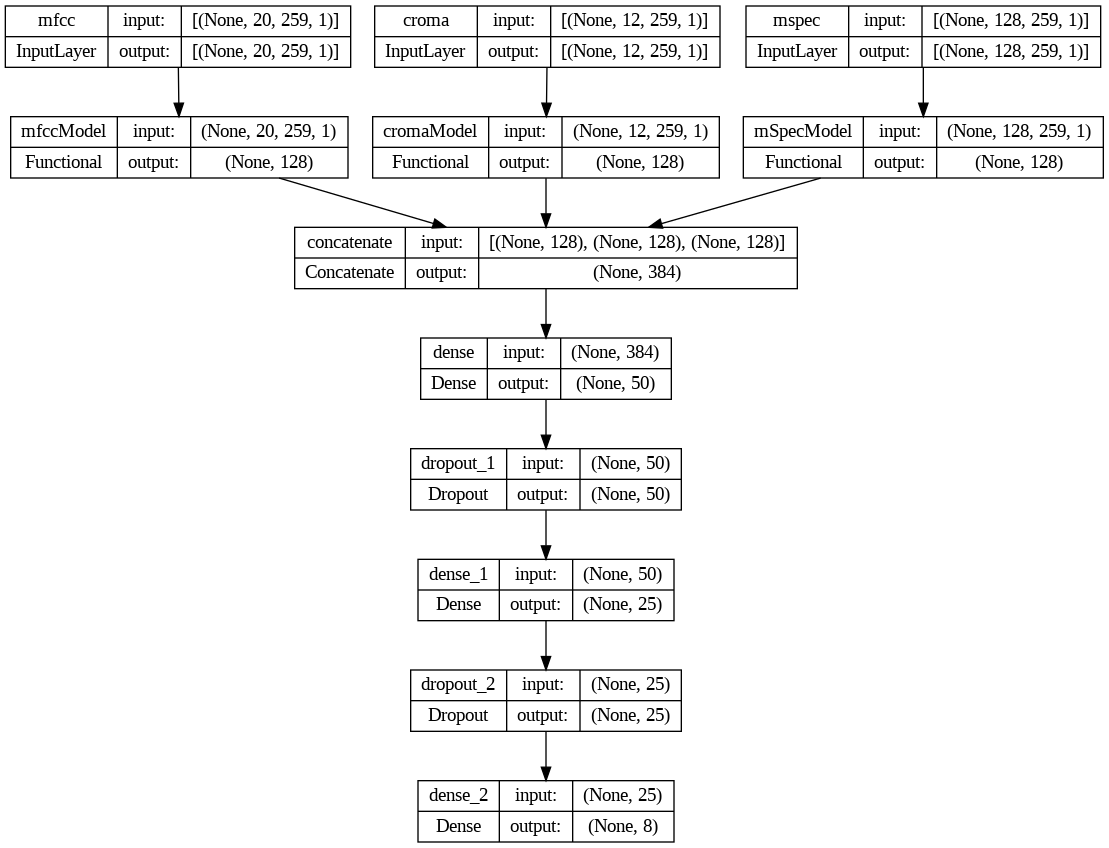

In [ ]:
keras.utils.plot_model(net, "net.png", show_shapes=True)

In [ ]:
from keras import backend as K
net.compile(loss='sparse_categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
K.set_value(net.optimizer.learning_rate, 0.001)

In [ ]:
history=net.fit(
    {"mfcc":mfcc_train,"croma":cstft_train,"mspec":mSpec_train},
    ytrain,
    validation_data=({"mfcc":mfcc_val,"croma":cstft_val,"mspec":mSpec_val},yval),
    epochs=100,verbose=0,
    callbacks=my_callbacks

)



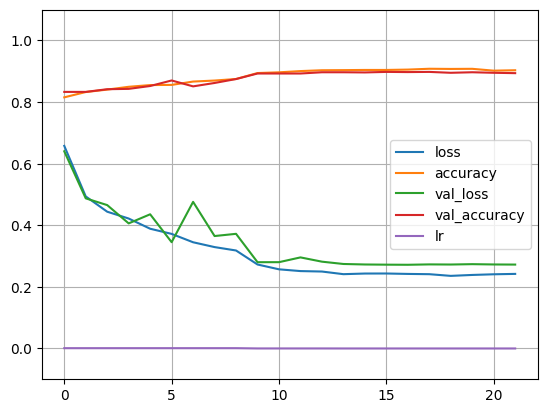

In [ ]:
pd.DataFrame(history.history).plot()
plt.grid(True)
plt.gca().set_ylim(-0.1,1.1)
plt.show()

In [ ]:
net.evaluate({"mfcc":mfcc_val,"croma":cstft_val,"mspec":mSpec_val},yval)

54/54 [==============================] - 8s 146ms/step - loss: 0.2724 - accuracy: 0.8939


[0.2724076807498932, 0.8939130306243896]

In [ ]:
net.save('/content/drive/MyDrive/Classification-of-Lung-Sound/lungs-model-mfcc.h5')